In [ ]:
# default_exp lars 

# lars

> using LARS-WG generated weather data sets



A common use case for models like AquaCrop-OSPy is to determine the impact of future climate change scenarios on crop production

LARS-WG is a weather generator (link) that can generate daily climate time series data for a specifc region under different climate change scenarios as global climate models

To help this kind of research we have developed some helpful functions so that LARS-WG generated timeseries can be directly incorperated into AquaCrop-OSPy

### Imports

In [ ]:
#export
import sys
_=[sys.path.append(i) for i in ['.', '..']]

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aquacrop.core import *
from aquacrop.classes import *
import seaborn as sns

In [ ]:
#export
def prepare_lars_weather(file,year,generated=True,order=["year","jday","minTemp","maxTemp","precip","rad"], wind_speed=3.4):
    """
    Uses FAO-PM to calculate reference evapotranspiration for LARS generated and baseline input data.
    
    """
    def vap_pres(t):
        return 0.6108*np.exp( (17.27*t)/(t+237.3) )
    
    df = pd.read_csv(file,delim_whitespace=True,header=None)
    
    if generated:
        df.columns=order
        df["tdelta"]=pd.to_timedelta(df.jday,unit='D')
        df["date"]=pd.to_datetime(f'{year-1}/12/31')+df["tdelta"]
        
        
        psyc=0.054 #sychometric constant
        tmean = (df.maxTemp+df.minTemp)/2
        e_s = (vap_pres(df.maxTemp)+vap_pres(df.minTemp))/2
        e_a = vap_pres(df.minTemp)
        slope = 4098*vap_pres(tmean)/(tmean+237.3)**2
        R_ns=(1-0.23)*df.rad
        sb_const = 4.903e-9
        R_nl = sb_const*0.5*((df.maxTemp+273.15)**4+(df.minTemp+273.15)**4)*(0.34-0.14*(e_a)**0.5)*(1.35*0.77-0.35)
        Rn = R_ns-R_nl
        u2=wind_speed

        eto = 0.408*slope*Rn+ (psyc*900*u2*(e_s-e_a)/(tmean+273))/(slope+psyc*(1+0.34*u2))
        df["eto"] = eto
        
        #df["eto"] = df.rad*(0.0023)*(((df.maxTemp+df.minTemp)/2)+17.8)*(df.maxTemp-df.minTemp)**0.5
        df.eto=df.eto.clip(0.1)
        df=df[["simyear","minTemp","maxTemp","precip","eto",'date']]
        df.columns=["simyear","MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]


    else:
        df.columns=order
        df['date'] = pd.to_datetime(df.year, format='%Y') + pd.to_timedelta(df.jday - 1, unit='d')
        
        psyc=0.054 #sychometric constant
        tmean = (df.maxTemp+df.minTemp)/2
        e_s = (vap_pres(df.maxTemp)+vap_pres(df.minTemp))/2
        e_a = vap_pres(df.minTemp)
        slope = 4098*vap_pres(tmean)/(tmean+237.3)**2
        R_ns=(1-0.23)*df.rad
        sb_const = 4.903e-9
        R_nl = sb_const*0.5*((df.maxTemp+273.15)**4+(df.minTemp+273.15)**4)*(0.34-0.14*(e_a)**0.5)*(1.35*0.77-0.35)
        Rn = R_ns-R_nl
        u2=wind_speed

        eto = 0.408*slope*Rn+ (psyc*900*u2*(e_s-e_a)/(tmean+273))/(slope+psyc*(1+0.34*u2))
        df["eto"] = eto
        
        #df["eto"] = df.rad*(0.0023)*(((df.maxTemp+df.minTemp)/2)+17.8)*(df.maxTemp-df.minTemp)**0.5
        df.eto=df.eto.clip(0.1)
        df=df[["minTemp","maxTemp","precip","eto",'date']]
        df.columns=["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]

        
    return df

In [ ]:
#export
def select_lars_wdf(df,simyear):
    temp =  df[df.simyear==simyear][["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]]
    return temp.reset_index(drop=True)

In [ ]:
#list_data()

In [ ]:
df=prepare_lars_weather(get_filepath('CP.dat'),-1,False,["year","jday","maxTemp","minTemp","precip","rad"])

In [ ]:
df.head()

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,3.89,17.22,0.00,1.868710,1981-05-20
1,6.67,21.67,0.00,2.665948,1981-05-21
2,5.56,25.00,2.01,3.420034,1981-05-22
3,5.56,19.44,0.00,2.440758,1981-05-23
4,5.56,24.44,0.00,3.520489,1981-05-24


In [ ]:
df_gen=prepare_lars_weather(get_filepath('CP_EC-EARTH[CP,RCP45,2041-2060]WG.dat'),2050,True,["simyear","jday","minTemp","maxTemp","precip","rad"])

In [ ]:
df_gen.head()

,simyear,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,1,-0.2,0.7,0.0,0.120413,2050-01-01
1,1,-9.1,20.8,0.0,3.571857,2050-01-02
2,1,-7.1,10.1,0.0,1.641596,2050-01-03
3,1,-4.0,18.3,0.0,2.675223,2050-01-04
4,1,-6.5,1.1,0.0,0.603963,2050-01-05


In [ ]:
select_lars_wdf(df_gen,1).head()

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,-0.2,0.7,0.0,0.120413,2050-01-01
1,-9.1,20.8,0.0,3.571857,2050-01-02
2,-7.1,10.1,0.0,1.641596,2050-01-03
3,-4.0,18.3,0.0,2.675223,2050-01-04
4,-6.5,1.1,0.0,0.603963,2050-01-05


In [ ]:
crop=CropClass('Maize',PlantingDate='05/01',HarvestDate='10/30',CalendarType=1,Emergence = 6,Senescence=107,MaxRooting=108,Maturity=132,HIstart=66,Flowering=13,YldForm=61,CDC=0.117,CGC=0.163)
          
soil=SoilClass('ClayLoam')
irrmngt=IrrMngtClass(1,SMT=[70]*4)

model=AquaCropModel('1982/05/01','2018/10/30',df,soil,crop,InitWCClass(),IrrMngt=irrmngt)
model.initialize()
model.step(till_termination=True)


In [ ]:
yields = model.Outputs.Final['Yield (tonne/ha)'].values;yields[:5]
tirrs = model.Outputs.Final['Seasonal irrigation (mm)'].values;tirrs[:5]

array([538.53079141, 572.34716376, 835.34774014, 808.63032224,
       663.77618937])

In [ ]:
ylist=[]
tlist=[]
a=[]
for i in range(100):
    wdf = select_lars_wdf(df_gen,i+1)
    
    model=AquaCropModel('2050/05/01','2050/10/30',wdf,soil,crop,InitWCClass(),IrrMngt=irrmngt)
    model.initialize()
    model.step(till_termination=True)
    ylist.append(model.Outputs.Final['Yield (tonne/ha)'].mean())
    tlist.append(model.Outputs.Final['Seasonal irrigation (mm)'].mean())
    
    a.append((model.Outputs.Final['Harvest Date (YYYY/MM/DD)']-pd.to_datetime('2050/05/01'))[0]/np.timedelta64(1,'D'))

In [ ]:
model.Outputs.Final

,Season,Crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,2050-09-10,131,14.810593,645.947284


In [ ]:
model.ParamStruct.CO2.CurrentConc

470.55

/home/tom/anaconda3/envs/aquacrop_new/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/tom/anaconda3/envs/aquacrop_new/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'yield')

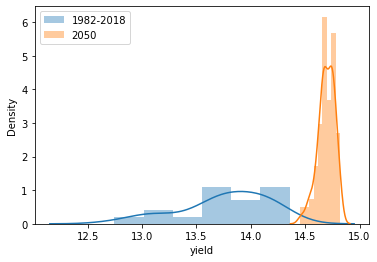

In [ ]:
sns.distplot(yields,label='1982-2018')
sns.distplot(np.array(ylist),label='2050')
plt.legend()
plt.xlabel('yield')

/home/tom/anaconda3/envs/aquacrop_new/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/tom/anaconda3/envs/aquacrop_new/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'tirr')

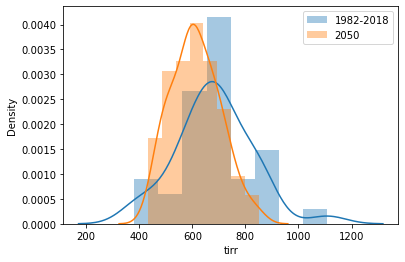

In [ ]:
sns.distplot(tirrs,label='1982-2018')
sns.distplot(np.array(tlist),label='2050')
plt.legend()
plt.xlabel('tirr')

In [ ]:

def run_model(crop):
    ylist=[]
    for i in range(100):
        wdf = select_lars_wdf(df_gen,i+1)

        model=AquaCropModel('2050/01/01','2050/12/31',wdf,soil,crop,InitWCClass())
        model.initialize()
        model.step(till_termination=True)
        ylist.append(model.Outputs.Final.Yield.mean())
        
    return np.mean(ylist)

In [ ]:
def run_model_old(crop):

    model=AquaCropModel('1982/01/01','2018/12/30',df,soil,crop,InitWCClass())
        #model=AquaCropModel('2050/01/01','2050/12/31',wdf,soil,crop)
    model.initialize()
    model.step(till_termination=True)
        
    return model.Outputs.Final.Yield.mean()

In [ ]:
# for i in range(1,23):
#     print(i)
#     start=pd.to_datetime('1982/01/01')
#     delta= np.timedelta64(7*i,'D')
#     plant=start+delta
#     harvest=plant+np.timedelta64(6,'M')


#     maize = CropClass('Maize',
#                       PlantingDate=plant.strftime("%m/%d"),
#                       HarvestDate=harvest.strftime("%m/%d"))
    
#     y=run_model_old(maize)
    


#     plt.scatter(i,y)

# plt.show()

In [ ]:
# for i in range(1,24):
#     print(i)
#     start=pd.to_datetime('2050/01/01')
#     delta= np.timedelta64(7*i,'D')
#     plant=start+delta
#     harvest=plant+np.timedelta64(6,'M')


#     maize = CropClass('Maize',
#                       PlantingDate=plant.strftime("%m/%d"),
#                       HarvestDate=harvest.strftime("%m/%d"))
    
#     y=run_model(maize)
    


#     plt.scatter(i,y)

# plt.show()